Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            11200     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 60)            26640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 80)            45120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               9

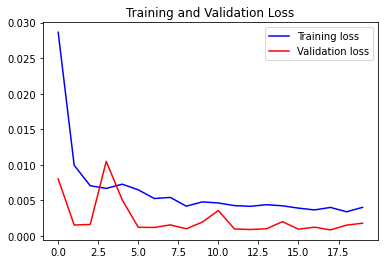

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv('BTC-USD.csv', date_parser = True)
data_training = data[data['Date']< '2020-01-01'].copy()
data_test = data[data['Date']< '2020-01-01'].copy()
training_data = data_training.drop(['Date', 'Adj Close'], axis = 1)

scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)

X_train = [] 
Y_train = []
for i in range(60, training_data.shape[0]):
    X_train.append(training_data[i-60:i])
    Y_train.append(training_data[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train.shape
    

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
#Initialize the RNN
model = Sequential() 
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 5)))
model.add(Dropout(0.2)) 
model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3)) 
model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4)) 
model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5)) 
model.add(Dense(units =1))
model.summary()

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history= model.fit(X_train, Y_train, epochs = 20, batch_size =50, validation_split=0.1)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


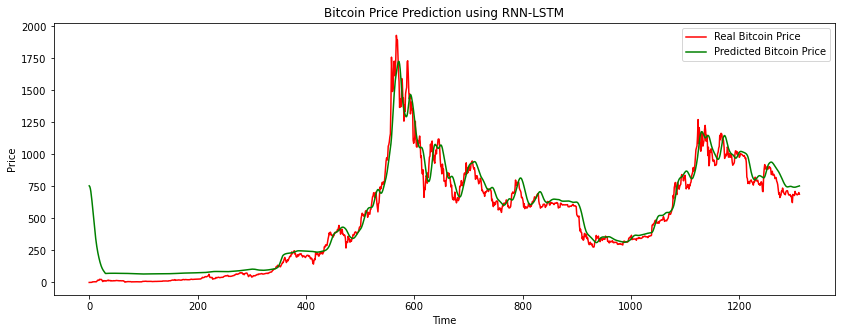

In [2]:
part_30_days = data_training.tail(30)
df= part_30_days.append(data_test, ignore_index = True)
df = df.drop(['Date', 'Adj Close'], axis = 1)

inputs = scaler.transform(df) 
X_test = []
Y_test = []
for i in range (30, inputs.shape[0]):
    X_test.append(inputs[i-30:i]) 
    Y_test.append(inputs[i, 0])
X_test, Y_test = np.array(X_test), np.array(Y_test)
Y_pred = model.predict(X_test)

scale = 1/5.18164146e-04
Y_test = Y_test*scale 
Y_pred = Y_pred*scale

plt.figure(figsize=(14,5))
plt.plot(Y_test, color = 'red', label = 'Real Bitcoin Price')
plt.plot(Y_pred, color = 'green', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

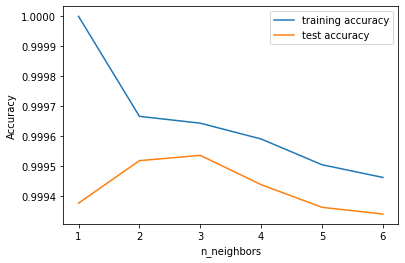

In [4]:
#K-neighbors regression

data_new = data.copy()
data_new = data_new.fillna(method='ffill')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X = data_new.drop(['Date','Close'], axis =1)
y = data_new['Close']

#split data
from sklearn.model_selection import train_test_split
X_train_org, X_test_org, y_train, y_test = train_test_split(X,y, test_size = 0.2,random_state = 20)

X_train = scaler.fit_transform(X_train_org)
X_test = scaler.transform(X_test_org)

from sklearn.model_selection import cross_val_score
scores = {}
cv_s= {}

from sklearn.neighbors import KNeighborsRegressor
training_accuracy = []
test_accuracy = []
neighbor_seetings = range(1,7)

for x in neighbor_seetings:
    knr = KNeighborsRegressor(n_neighbors = x)
    knr.fit(X_train, y_train)
    training_accuracy.append(knr.score(X_train, y_train))
    test_accuracy.append(knr.score(X_test,y_test))

# Show the relationship of accuarcy and n_neighbors
plt.plot(neighbor_seetings, training_accuracy, label = 'training accuracy')
plt.plot(neighbor_seetings, test_accuracy, label = 'test accuracy')
plt.ylabel("Accuracy")
plt.xlabel('n_neighbors')
plt.legend()

In [5]:
scores['K-neighbors regression'] = [training_accuracy[2],test_accuracy[2]]

# Cross Validation
knr = KNeighborsRegressor(n_neighbors = 3)
cv_scores = cross_val_score(knr, X_train, y_train,cv = 5)
print('Cross-validation training scores (5-fold):', cv_scores)
print('Mean cross-validation training score (5-fold): {:.3f}'.format(np.mean(cv_scores)))
cv_test_scores = cross_val_score(knr, X_test, y_test,cv = 5)
cv_s['K-neighbors regression']=[np.mean(cv_scores),np.mean(cv_test_scores)]

Cross-validation training scores (5-fold): [0.99932589 0.99910245 0.99892081 0.99939816 0.99884013]
Mean cross-validation training score (5-fold): 0.999


In [6]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

lr.fit(X_train, y_train)
print('Train score: {}'.format(lr.score(X_train, y_train)))
print('Test score: {}'.format(lr.score(X_test,y_test)))
scores['LinearRegression']=[lr.score(X_train, y_train),lr.score(X_test,y_test)]

Train score: 1.0
Test score: 1.0


In [7]:
# Cross Validation
cv_scores = cross_val_score(lr, X_train, y_train,cv = 5)
print('Cross-validation training scores (5-fold):', cv_scores)
print('Mean cross-validation training score (5-fold): {:.3f}'.format(np.mean(cv_scores)))
cv_test_scores = cross_val_score(lr, X_test, y_test,cv = 5)
cv_s['LinearRegression']=[np.mean(cv_scores),np.mean(cv_test_scores)]

Cross-validation training scores (5-fold): [1. 1. 1. 1. 1.]
Mean cross-validation training score (5-fold): 1.000


In [8]:
# Alpha by default is 1.0
from sklearn.linear_model import Ridge
ridge = Ridge()
ridge.fit(X_train, y_train)
print('Train score: {}'.format(ridge.score(X_train, y_train)))
print('Test score: {}'.format(ridge.score(X_test,y_test)))

Train score: 0.9993162505957485
Test score: 0.9994366519277343


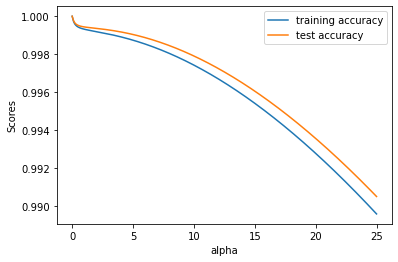

In [9]:
a =np.linspace(0.001,25,1000)
training_accuracy = []
test_accuracy = []
for x in a:
    ridge = Ridge(alpha = x)
    ridge.fit(X_train, y_train)
    training_accuracy.append(ridge.score(X_train, y_train))
    test_accuracy.append(ridge.score(X_test,y_test))
    
plt.plot(a, training_accuracy, label = 'training accuracy')
plt.plot(a, test_accuracy, label = 'test accuracy')
plt.ylabel("Scores")
plt.xlabel('alpha')
plt.legend()

In [10]:
# Use GridSearchCV to find the best alpha
from sklearn.model_selection import GridSearchCV

ridge = Ridge()
param_grid = {'alpha':[0.001,0.01, 0.1,1]}

grid_search = GridSearchCV(ridge, param_grid, cv = 5)
grid_search.fit(X_train, y_train)

#use gridsearch to get the best parameters, alpha=0.001
print('Best parameters{}'.format(grid_search.best_params_))
print('Best score {:.2f}'.format(grid_search.best_score_))

Best parameters{'alpha': 0.001}
Best score 1.00


In [11]:
ridge = Ridge(alpha = 0.001)
ridge.fit(X_train, y_train)
scores['Ridge']=[ridge.score(X_train, y_train),ridge.score(X_test,y_test)]

# Cross Validation
cv_scores = cross_val_score(ridge, X_train, y_train,cv = 5)
print('Cross-validation training scores (5-fold):', cv_scores)
print('Mean cross-validation training score (5-fold): {:.3f}'.format(np.mean(cv_scores)))
cv_test_scores = cross_val_score(ridge, X_test, y_test,cv = 5)
cv_s['Ridge']=[np.mean(cv_scores),np.mean(cv_test_scores)]

Cross-validation training scores (5-fold): [0.99999964 0.99999818 0.99999941 0.99999933 0.99999913]
Mean cross-validation training score (5-fold): 1.000


In [12]:
from sklearn.linear_model import Lasso

lasso = Lasso(max_iter = 100000)
lasso.fit(X_train, y_train)
print('Train score: {}'.format(lasso.score(X_train, y_train)))
print('Test score: {}'.format(lasso.score(X_test,y_test)))
print('Number of features used: {}'.format(np.sum(lasso.coef_ != 0)))

Train score: 0.9999952394102118
Test score: 0.9999957755483675
Number of features used: 3


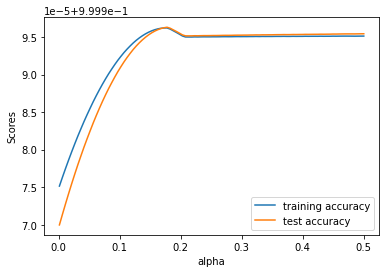

In [13]:
a =np.linspace(0.001,0.5,100)
training_accuracy = []
test_accuracy = []
f = []
for x in a:
    lasso = Lasso(alpha = x, max_iter = 100000)
    lasso.fit(X_train, y_train)
    training_accuracy.append(lasso.score(X_train, y_train))
    test_accuracy.append(lasso.score(X_test,y_test))
    f.append(np.sum(lasso.coef_!=0))
plt.plot(a, training_accuracy, label = 'training accuracy')
plt.plot(a, test_accuracy, label = 'test accuracy')
plt.ylabel("Scores")
plt.xlabel('alpha')
plt.legend()

In [14]:
lasso = Lasso(max_iter = 100000)
param_grid = {'alpha':[0.017, 0.02, 0.023, 0.026]}

grid_search = GridSearchCV(lasso, param_grid, cv = 5)
grid_search.fit(X_train, y_train)

print('Best parameters{}'.format(grid_search.best_params_))
print('Best score {}'.format(grid_search.best_score_))

Best parameters{'alpha': 0.026}
Best score 0.9999732488670249


In [15]:
lasso = Lasso(alpha = 0.023,max_iter = 100000)
lasso.fit(X_train, y_train)
scores['Lasso']=[lasso.score(X_train, y_train),lasso.score(X_test,y_test)]

# Cross Validation
cv_scores = cross_val_score(lasso, X_train, y_train,cv = 5)
print('Cross-validation training scores (5-fold):', cv_scores)
print('Mean cross-validation training score (5-fold): {:.3f}'.format(np.mean(cv_scores)))
cv_test_scores = cross_val_score(lasso, X_test, y_test,cv = 5)
cv_s['Lasso']=[np.mean(cv_scores),np.mean(cv_test_scores)]

Cross-validation training scores (5-fold): [0.99998535 0.99997784 0.9999354  0.99997978 0.99998393]
Mean cross-validation training score (5-fold): 1.000


In [39]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)
X_train_py, X_test_py, y_train, y_test = train_test_split(X_poly, y, test_size = 0.2, random_state = 20)

linreg = LinearRegression()
linreg.fit(X_train_py, y_train)
print('Polynomial LinearRegression')
print('Train score: {}'.format(linreg.score(X_train_py, y_train)))
print('Test score: {}\n'.format(linreg.score(X_test_py,y_test)))
scores['Polynomial deg 2 LinearRegression']=[linreg.score(X_train_py, y_train),linreg.score(X_test_py,y_test)]

linridge = Ridge()
linridge.fit(X_train_py, y_train)
print('Polynomial Ridge Regression')
print('Train score: {}'.format(linridge.score(X_train_py, y_train)))
print('Test score: {}\n'.format(linridge.score(X_test_py,y_test)))
scores['Polynomial deg 2 Ridge Regression']=[linridge.score(X_train_py, y_train),linridge.score(X_test_py,y_test)]

linlasso = Lasso()
linlasso.fit(X_train_py, y_train)
print('Polynomial Lasso Regression')
print('Train score: {}'.format(linlasso.score(X_train_py, y_train)))
print('Test score: {}'.format(linlasso.score(X_test_py,y_test)))
scores['Polynomial deg 2 Lasso Regression']=[linlasso.score(X_train_py, y_train),linlasso.score(X_test_py,y_test)]

Polynomial LinearRegression
Train score: 0.5392305009500179
Test score: 0.4182252796934749

Polynomial Ridge Regression
Train score: 1.0
Test score: 1.0

Polynomial Lasso Regression
Train score: 0.9997876138507856
Test score: 0.9997529392692114


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.30427e-70): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24201407.201271385, tolerance: 22788632.617451467
  model = cd_fast.enet_coordinate_descent(


In [40]:
# Cross Validation
cv_scores = cross_val_score(linreg, X_train_py, y_train,cv = 5)
print('Cross-validation training scores (5-fold):', cv_scores)
print('Mean cross-validation training score (5-fold): {:.3f}'.format(np.mean(cv_scores)))
cv_test_scores = cross_val_score(linreg, X_test_py, y_test,cv = 5)
cv_s['Polynomial deg 2 LinearRegression']=[np.mean(cv_scores),np.mean(cv_test_scores)]

cv_scores = cross_val_score(linridge, X_train_py, y_train,cv = 5)
print('Cross-validation training scores (5-fold):', cv_scores)
print('Mean cross-validation training score (5-fold): {:.3f}'.format(np.mean(cv_scores)))
cv_test_scores = cross_val_score(linridge, X_test_py, y_test,cv = 5)
cv_s['Polynomial deg 2 Ridge Regression']=[np.mean(cv_scores),np.mean(cv_test_scores)]

cv_scores = cross_val_score(linlasso, X_train_py, y_train,cv = 5)
print('Cross-validation training scores (5-fold):', cv_scores)
print('Mean cross-validation training score (5-fold): {:.3f}'.format(np.mean(cv_scores)))
cv_test_scores = cross_val_score(linlasso, X_test_py, y_test,cv = 5)
cv_s['Polynomial deg 2 Lasso Regression']=[np.mean(cv_scores),np.mean(cv_test_scores)]

Cross-validation training scores (5-fold): [ 9.12971020e-01 -1.08087774e+03  7.38859440e-01  8.88364188e-01
  8.04634444e-01]
Mean cross-validation training score (5-fold): -215.507
Cross-validation training scores (5-fold): [1. 1. 1. 1. 1.]
Mean cross-validation training score (5-fold): 1.000


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.31112e-70): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.10542e-68): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.32497e-70): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.3124e-70): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.31266e-70): result may not be accurate.
  re

Cross-validation training scores (5-fold): [0.9998517  0.99613265 0.9996388  0.99979938 0.99974814]
Mean cross-validation training score (5-fold): 0.999


In [41]:
from sklearn.svm import SVR
# SVM, with kernel: (linear)
svr = SVR(kernel = 'linear')
svr.fit(X_train, y_train)
print('Train score: {}'.format(svr.score(X_train, y_train)))
print('Test score: {}\n'.format(svr.score(X_test,y_test)))
scores['SVM']=[svr.score(X_train, y_train),svr.score(X_test,y_test)]

cv_scores = cross_val_score(svr, X_train, y_train,cv = 5)
print('Cross-validation training scores (5-fold):', cv_scores)
print('Mean cross-validation training score (5-fold): {:.3f}'.format(np.mean(cv_scores)))
cv_test_scores = cross_val_score(svr, X_test, y_test,cv = 5)
cv_s['SVM']=[np.mean(cv_scores),np.mean(cv_test_scores)]

Train score: -0.029616789591155657
Test score: -0.024996999777163964

Cross-validation training scores (5-fold): [-0.02704086 -0.06123174 -0.02604041 -0.04630751 -0.01222485]
Mean cross-validation training score (5-fold): -0.035


In [42]:
# SVR without kernel
from sklearn.svm import LinearSVR
lsvr = LinearSVR()
lsvr.fit(X_train, y_train)
print('Train score: {}'.format(lsvr.score(X_train, y_train)))
print('Test score: {}\n'.format(lsvr.score(X_test,y_test)))
scores['SVM without kernel']=[lsvr.score(X_train, y_train),lsvr.score(X_test,y_test)]

# Cross Validation
cv_scores = cross_val_score(lsvr, X_train, y_train,cv = 5)
print('Cross-validation training scores (5-fold):', cv_scores)
print('Mean cross-validation training score (5-fold): {:.3f}'.format(np.mean(cv_scores)))
cv_test_scores = cross_val_score(lsvr, X_test, y_test,cv = 5)
cv_s['SVM without kernel']=[np.mean(cv_scores),np.mean(cv_test_scores)]

Train score: -0.47739993163827266
Test score: -0.4660884791514932

Cross-validation training scores (5-fold): [-0.46051446 -0.51379252 -0.55381499 -0.51281525 -0.49992738]
Mean cross-validation training score (5-fold): -0.508


In [43]:
df = pd.DataFrame(scores).T
df.columns = ['Train Score','Test Score']
df = pd.concat([df,pd.DataFrame(cv_s,index = [['Cross_Validation_Train_Score','Cross_Validation_Test_Score']]).T],axis=1, join='inner')
df

,Train Score,Test Score,"(Cross_Validation_Train_Score,)","(Cross_Validation_Test_Score,)"
K-neighbors regression,0.999644,0.999537,0.999117,0.997454
LinearRegression,1.000000,1.000000,1.000000,1.000000
Ridge,1.000000,1.000000,0.999999,0.999985
Lasso,0.999980,0.999976,0.999972,0.999958
Polynomial deg 2 LinearRegression,0.539231,0.418225,-215.506583,0.806509
Polynomial deg 2 Ridge Regression,1.000000,1.000000,1.000000,1.000000
Polynomial deg 2 Lasso Regression,0.999788,0.999753,0.999034,0.999480
SVM,-0.029617,-0.024997,-0.034569,-0.049605
SVM without kernel,-0.477400,-0.466088,-0.508173,-0.633814
Polynomial deg 3 LinearRegression,0.539231,0.418225,-215.506583,0.806509
